# Packages

In [132]:
# Data wrangling
import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np

# Visualisation
import plotnine as pn
import matplotlib.pyplot as plt
from mizani.formatters import comma_format, custom_format, currency_format, percent_format
from IPython.display import clear_output, display
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
import plotly.express as px

# Utils
import os
from tqdm.notebook import tqdm
import itertools
import yaml
import warnings
import time
import holidays

# Modelling
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
    root_mean_squared_error,
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer


from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsforecast.models import AutoARIMA, ARIMA
from statsforecast.utils import AirPassengers as ap

import ray
from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler


rc('text', usetex=False)

jama_colour = [
    "#374e55",
    "#df8f44",
    "#00a1d5",
    "#b24745",
    "#79af97",
    "#6a6599",
    "#80796b",
]

pd.set_option("display.max.columns", 500)
pd.set_option("display.max.columns", 500)


theme_academic = pn.theme(
    text=pn.element_text(family="Latin Modern Roman"),
    plot_title=pn.element_text(weight="bold", size=14, ha="center"),
    legend_text=pn.element_text(size=9),  # Smaller font for legend items
    panel_background=pn.element_rect(fill="white"),  # Clean white background
    panel_border=pn.element_rect(color="grey", size=0.5),
    axis_ticks=pn.element_line(color="grey"),
    panel_grid_major=pn.element_line(color="grey", size=0.1, alpha=0.3),
    panel_grid_minor=pn.element_line(color="grey", size=0.1, alpha=0.3),
    legend_background=pn.element_rect(fill="white", color=None),
    legend_key=pn.element_rect(fill="white", color=None),
    plot_margin=0.02,
    figure_size=(6, 4),  # Set default figure size (width, height in inches)
)

%matplotlib inline

# Loading the data

In [133]:
df = pl.read_csv("../0_data/preprocessed/df_final_reduced.csv", try_parse_dates=True)


df.head()

datetime,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm
datetime[μs],f64,f64,f64
2021-09-01 00:00:00,5.1633e6,0.0,16.042
2021-09-01 01:00:00,5.0777e6,0.0,15.892
2021-09-01 02:00:00,4.9315e6,0.0,16.042
2021-09-01 03:00:00,4.7878e6,0.0,15.942
2021-09-01 04:00:00,4.7038e6,0.0,15.792001


In [134]:
df.shape

(26304, 4)

In [135]:
df

datetime,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm
datetime[μs],f64,f64,f64
2021-09-01 00:00:00,5.1633e6,0.0,16.042
2021-09-01 01:00:00,5.0777e6,0.0,15.892
2021-09-01 02:00:00,4.9315e6,0.0,16.042
2021-09-01 03:00:00,4.7878e6,0.0,15.942
2021-09-01 04:00:00,4.7038e6,0.0,15.792001
…,…,…,…
2024-08-31 19:00:00,5.3614e6,179.0,22.942
2024-08-31 20:00:00,5.3775e6,41.0,23.042
2024-08-31 21:00:00,5.2130e6,0.0,23.092


# Missing values

Just forward fill for now.

In [136]:
df = df.fill_null(strategy="forward")

# Lags

Include target variable lags.

- Same hour on previous day
- Average consumption during the past week

In [137]:
lags_24h = (
    df.select("datetime", "kWh")
    .with_columns(pl.col("datetime").dt.offset_by("1d"))
    .rename({"kWh": "kWh_lag_24"})
)

In [138]:
lags_rolling_1w = (
    df.select("datetime", "kWh")
    .with_columns(pl.col("kWh").rolling_mean(window_size=24 * 7))
    .with_columns(pl.col("datetime").dt.offset_by("1d"))
    .rename({"kWh": "kWh_rolling_1w"})
)

In [139]:
df = df.join(lags_24h, how="left", on="datetime", coalesce=True).join(
    lags_rolling_1w, how="left", on="datetime", coalesce=True
)

In [140]:
df = df.filter(pl.col("datetime") >= pd.Timestamp("2021-09-01 00:00"))

# Calendar Features

In [141]:
df = df.with_columns(
    day_of_month=pl.col("datetime").dt.day(),
    day_of_year=pl.col("datetime").dt.ordinal_day(),
    day_of_week=pl.col("datetime").dt.weekday(),
    month=pl.col("datetime").dt.month(),
    hour=pl.col("datetime").dt.hour(),
    year=pl.col("datetime").dt.year(),
)

# Interaction Terms

In [142]:
from itertools import combinations

In [143]:
raw_cols = df.drop(["datetime", "kWh"]).select(pl.selectors.numeric()).columns
interaction_cols = list(combinations(iterable=raw_cols, r=2))

In [144]:
for col1, col2 in tqdm(interaction_cols):
    df = df.with_columns(
        pl.col(col1).mul(pl.col(col2)).alias(f"interaction_{col1}_{col2}")
    )

  0%|          | 0/45 [00:00<?, ?it/s]

# Polynomials

In [145]:
pol_degrees = 5

for col in tqdm(raw_cols):
    for degree in range(2, pol_degrees + 1):
        df = df.with_columns(
            pl.col(col).pow(degree).alias(f"polynomial_{degree}_{col}")
        )

  0%|          | 0/10 [00:00<?, ?it/s]

# Holidays

In [146]:
# Define the region (Canton of Berne) and the country (Switzerland)
country = "CH"
prov = "ZH"

# Create a list of the regional holidays for the canton of Berne
regional_holidays = holidays.CH(
    years=df["datetime"].dt.year().unique().to_list(), prov=prov
)

In [147]:
holiday_df = pl.DataFrame(
    {
        "holiday_name": list(regional_holidays.values()),
        "holiday_date": list(regional_holidays.keys()),
    }
).sort("holiday_date")

holiday_df.head()

holiday_name,holiday_date
str,date
"""Neujahrestag""",2021-01-01
"""Berchtoldstag""",2021-01-02
"""Karfreitag""",2021-04-02
"""Ostermontag""",2021-04-05
"""Tag der Arbeit""",2021-05-01


In [148]:
df = (
    df.with_columns(date=pl.col("datetime").dt.date())
    .join(holiday_df, how="left", left_on="date", right_on="holiday_date")
    .drop("date")
)

df.head()

datetime,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm,kWh_lag_24,kWh_rolling_1w,day_of_month,day_of_year,day_of_week,month,hour,year,interaction_Zurich_shortwave_radiation_Zurich_soil_temperature_7_to_28cm,interaction_Zurich_shortwave_radiation_kWh_lag_24,interaction_Zurich_shortwave_radiation_kWh_rolling_1w,interaction_Zurich_shortwave_radiation_day_of_month,interaction_Zurich_shortwave_radiation_day_of_year,interaction_Zurich_shortwave_radiation_day_of_week,interaction_Zurich_shortwave_radiation_month,interaction_Zurich_shortwave_radiation_hour,interaction_Zurich_shortwave_radiation_year,interaction_Zurich_soil_temperature_7_to_28cm_kWh_lag_24,interaction_Zurich_soil_temperature_7_to_28cm_kWh_rolling_1w,interaction_Zurich_soil_temperature_7_to_28cm_day_of_month,interaction_Zurich_soil_temperature_7_to_28cm_day_of_year,interaction_Zurich_soil_temperature_7_to_28cm_day_of_week,interaction_Zurich_soil_temperature_7_to_28cm_month,interaction_Zurich_soil_temperature_7_to_28cm_hour,interaction_Zurich_soil_temperature_7_to_28cm_year,interaction_kWh_lag_24_kWh_rolling_1w,interaction_kWh_lag_24_day_of_month,interaction_kWh_lag_24_day_of_year,interaction_kWh_lag_24_day_of_week,interaction_kWh_lag_24_month,interaction_kWh_lag_24_hour,interaction_kWh_lag_24_year,interaction_kWh_rolling_1w_day_of_month,…,polynomial_2_Zurich_soil_temperature_7_to_28cm,polynomial_3_Zurich_soil_temperature_7_to_28cm,polynomial_4_Zurich_soil_temperature_7_to_28cm,polynomial_5_Zurich_soil_temperature_7_to_28cm,polynomial_2_kWh_lag_24,polynomial_3_kWh_lag_24,polynomial_4_kWh_lag_24,polynomial_5_kWh_lag_24,polynomial_2_kWh_rolling_1w,polynomial_3_kWh_rolling_1w,polynomial_4_kWh_rolling_1w,polynomial_5_kWh_rolling_1w,polynomial_2_day_of_month,polynomial_3_day_of_month,polynomial_4_day_of_month,polynomial_5_day_of_month,polynomial_2_day_of_year,polynomial_3_day_of_year,polynomial_4_day_of_year,polynomial_5_day_of_year,polynomial_2_day_of_week,polynomial_3_day_of_week,polynomial_4_day_of_week,polynomial_5_day_of_week,polynomial_2_month,polynomial_3_month,polynomial_4_month,polynomial_5_month,polynomial_2_hour,polynomial_3_hour,polynomial_4_hour,polynomial_5_hour,polynomial_2_year,polynomial_3_year,polynomial_4_year,polynomial_5_year,holiday_name
datetime[μs],f64,f64,f64,f64,f64,i8,i16,i8,i8,i8,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i8,i8,i16,i16,i16,i16,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i32,i32,i32,i32,str
2021-09-01 00:00:00,5.1633e6,0.0,16.042,null,null,1,244,3,9,0,2021,0.0,null,null,0.0,0.0,0.0,0.0,0.0,0.0,null,null,16.042,3914.248,48.126,144.378,0.0,32420.882,null,null,null,null,null,null,null,null,…,257.345764,4128.340746,66226.842249,1.0624e6,null,null,null,null,null,null,null,null,1,1,1,1,-6000,-22208,20736,13312,9,27,81,-13,81,-39,-95,-87,0,0,0,0,4084441,-335279331,1005304817,201504149,null
2021-09-01 01:00:00,5.0777e6,0.0,15.892,null,null,1,244,3,9,1,2021,0.0,null,null,0.0,0.0,0.0,0.0,0.0,0.0,null,null,15.892,3877.648,47.676,143.028,15.892,32117.732,null,null,null,null,null,null,null,null,…,252.555664,4013.614612,63784.363418,1.0137e6,null,null,null,null,null,null,null,null,1,1,1,1,-6000,-22208,20736,13312,9,27,81,-13,81,-39,-95,-87,1,1,1,1,4084441,-335279331,1005304817,201504149,null
2021-09-01 02:00:00,4.9315e6,0.0,16.042,null,null,1,244,3,9,2,2021,0.0,null,null,0.0,0.0,0.0,0.0,0.0,0.0,null,null,16.042,3914.248,48.126,144.378,32.084,32420.882,null,null,null,null,null,null,null,null,…,257.345764,4128.340746,66226.842249,1.0624e6,null,null,null,null,null,null,null,null,1,1,1,1,-6000,-22208,20736,13312,9,27,81,-13,81,-39,-95,-87,4,8,16,32,4084441,-335279331,1005304817,201504149,null
2021-09-01 03:00:00,4.7878e6,0.0,15.942,null,null,1,244,3,9,3,2021,0.0,null,null,0.0,0.0,0.0,0.0,0.0,0.0,null,null,15.942,3889.848,47.826,143.478,47.826,32218.782,null,null,null,null,null,null,null,null,…,254.147364,4051.617277,64590.882

# sklearn Pipeline

In [ ]:
cat_cols = [
    "holiday_name",
    "day_of_month",
    "day_of_year",
    "day_of_week",
    "month",
    "hour",
    "year",
]


num_cols = [
    "Zurich_shortwave_radiation",
    "Zurich_soil_temperature_7_to_28cm",
    "kWh_lag_24",
    "kWh_rolling_1w",
] + df.select(pl.selectors.contains("polynomial_", "interaction_")).columns


manual_cols = []

In [165]:
df.drop(manual_cols + cat_cols + num_cols).columns

['datetime', 'kWh']

In [166]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

In [167]:
categorical_transformer = Pipeline(
    steps=[
        (
            "encoder",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        ),
    ]
)

In [168]:
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, num_cols),
        ("categorical", categorical_transformer, cat_cols),
    ],
    remainder="passthrough",
)

# Hyperparameter Tuning

In [169]:
df_full = (
    df.to_pandas()
    .assign(datetime=lambda x: x.datetime.astype("datetime64[ns]"))
    .set_index("datetime")
    .asfreq("h")
    .sort_index()
)
df_full.head()

,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm,kWh_lag_24,kWh_rolling_1w,day_of_month,day_of_year,day_of_week,month,hour,year,interaction_Zurich_shortwave_radiation_Zurich_soil_temperature_7_to_28cm,interaction_Zurich_shortwave_radiation_kWh_lag_24,interaction_Zurich_shortwave_radiation_kWh_rolling_1w,interaction_Zurich_shortwave_radiation_day_of_month,interaction_Zurich_shortwave_radiation_day_of_year,interaction_Zurich_shortwave_radiation_day_of_week,interaction_Zurich_shortwave_radiation_month,interaction_Zurich_shortwave_radiation_hour,interaction_Zurich_shortwave_radiation_year,interaction_Zurich_soil_temperature_7_to_28cm_kWh_lag_24,interaction_Zurich_soil_temperature_7_to_28cm_kWh_rolling_1w,interaction_Zurich_soil_temperature_7_to_28cm_day_of_month,interaction_Zurich_soil_temperature_7_to_28cm_day_of_year,interaction_Zurich_soil_temperature_7_to_28cm_day_of_week,interaction_Zurich_soil_temperature_7_to_28cm_month,interaction_Zurich_soil_temperature_7_to_28cm_hour,interaction_Zurich_soil_temperature_7_to_28cm_year,interaction_kWh_lag_24_kWh_rolling_1w,interaction_kWh_lag_24_day_of_month,interaction_kWh_lag_24_day_of_year,interaction_kWh_lag_24_day_of_week,interaction_kWh_lag_24_month,interaction_kWh_lag_24_hour,interaction_kWh_lag_24_year,interaction_kWh_rolling_1w_day_of_month,interaction_kWh_rolling_1w_day_of_year,interaction_kWh_rolling_1w_day_of_week,interaction_kWh_rolling_1w_month,interaction_kWh_rolling_1w_hour,interaction_kWh_rolling_1w_year,interaction_day_of_month_day_of_year,interaction_day_of_month_day_of_week,interaction_day_of_month_month,interaction_day_of_month_hour,interaction_day_of_month_year,interaction_day_of_year_day_of_week,interaction_day_of_year_month,interaction_day_of_year_hour,interaction_day_of_year_year,interaction_day_of_week_month,interaction_day_of_week_hour,interaction_day_of_week_year,interaction_month_hour,interaction_month_year,interaction_hour_year,polynomial_2_Zurich_shortwave_radiation,polynomial_3_Zurich_shortwave_radiation,polynomial_4_Zurich_shortwave_radiation,polynomial_5_Zurich_shortwave_radiation,polynomial_2_Zurich_soil_temperature_7_to_28cm,polynomial_3_Zurich_soil_temperature_7_to_28cm,polynomial_4_Zurich_soil_temperature_7_to_28cm,polynomial_5_Zurich_soil_temperature_7_to_28cm,polynomial_2_kWh_lag_24,polynomial_3_kWh_lag_24,polynomial_4_kWh_lag_24,polynomial_5_kWh_lag_24,polynomial_2_kWh_rolling_1w,polynomial_3_kWh_rolling_1w,polynomial_4_kWh_rolling_1w,polynomial_5_kWh_rolling_1w,polynomial_2_day_of_month,polynomial_3_day_of_month,polynomial_4_day_of_month,polynomial_5_day_of_month,polynomial_2_day_of_year,polynomial_3_day_of_year,polynomial_4_day_of_year,polynomial_5_day_of_year,polynomial_2_day_of_week,polynomial_3_day_of_week,polynomial_4_day_of_week,polynomial_5_day_of_week,polynomial_2_month,polynomial_3_month,polynomial_4_month,polynomial_5_month,polynomial_2_hour,polynomial_3_hour,polynomial_4_hour,polynomial_5_hour,polynomial_2_year,polynomial_3_year,polynomial_4_year,polynomial_5_year,holiday_name
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-01 00:00:00,5.163270e+06,0.0,16.042000,NaN,NaN,1,244,3,9,0,2021,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,16.042000,3914.248000,48.126000,144.378000,0.000000,32420.882000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,244,3,9,0,2021,732,2196,0,493124,27,0,6063,0,18189,0,0.0,0.0,0.0,0.0,257.345764,4128.340746,66226.842249,1.062411e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,-6000,-22208,20736,13312,9,27,81,-13,81,-39,-95,-87,0,0,0,0,4084441,-335279331,1005304817,201504149,None
2021-09-01 01:00:00,5.077656e+06,0.0,15.892000,NaN,NaN,1,244,3,9,1,2021,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,15.892000,3877.648000,47.676000,143.028000,15.892000,32117.732000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,244,3,9,1,2021,732,2196,244,493124,27,3,6063,9,18189,2021,0.0,0.0,0.0,0.0,252.555664,4013.614612,63784.363418,1.013661e+06,NaN

In [170]:
df_train_val = df_full["2021-09-01":"2023-08-31"]
# df_val = df_full["2022-07-01":"2023-07-31"]

In [171]:
tscv = TimeSeriesSplit(n_splits=5, max_train_size=365 * 24, test_size=int(365 * 24 / 5))

target_splits = []

X_train_preprocessed_list = []
X_val_preprocessed_list = []
y_train_list = []
y_val_list = []

for split_idx, (train_index, val_index) in enumerate(tscv.split(df_train_val)):

    # Create X splits
    X_train = df_train_val.iloc[train_index].drop(columns="kWh")
    X_val = df_train_val.iloc[val_index].drop(columns="kWh")

    X_train_preprocessed = pd.DataFrame(
        preprocessor.fit_transform(X_train),
        columns=preprocessor.get_feature_names_out(),
    )
    X_train_preprocessed_list.append(X_train_preprocessed)

    X_val_preprocessed = pd.DataFrame(
        preprocessor.transform(X_val),
        columns=preprocessor.get_feature_names_out(),
    )
    X_val_preprocessed_list.append(X_val_preprocessed)

    # Create y splits
    y_train = df_train_val.iloc[train_index]["kWh"]
    y_train_list.append(y_train)

    y_val = df_train_val.iloc[val_index]["kWh"]
    y_val_list.append(y_val)

    # Create dataframe for plotting the TimeSeries CV
    target_split = pd.concat(
        [
            y_train.reset_index().assign(Period="Training"),
            y_val.reset_index().assign(Period="Validation"),
        ]
    ).assign(split=split_idx + 1)

    target_splits.append(target_split)

matplotlib.font_manager INFO  Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


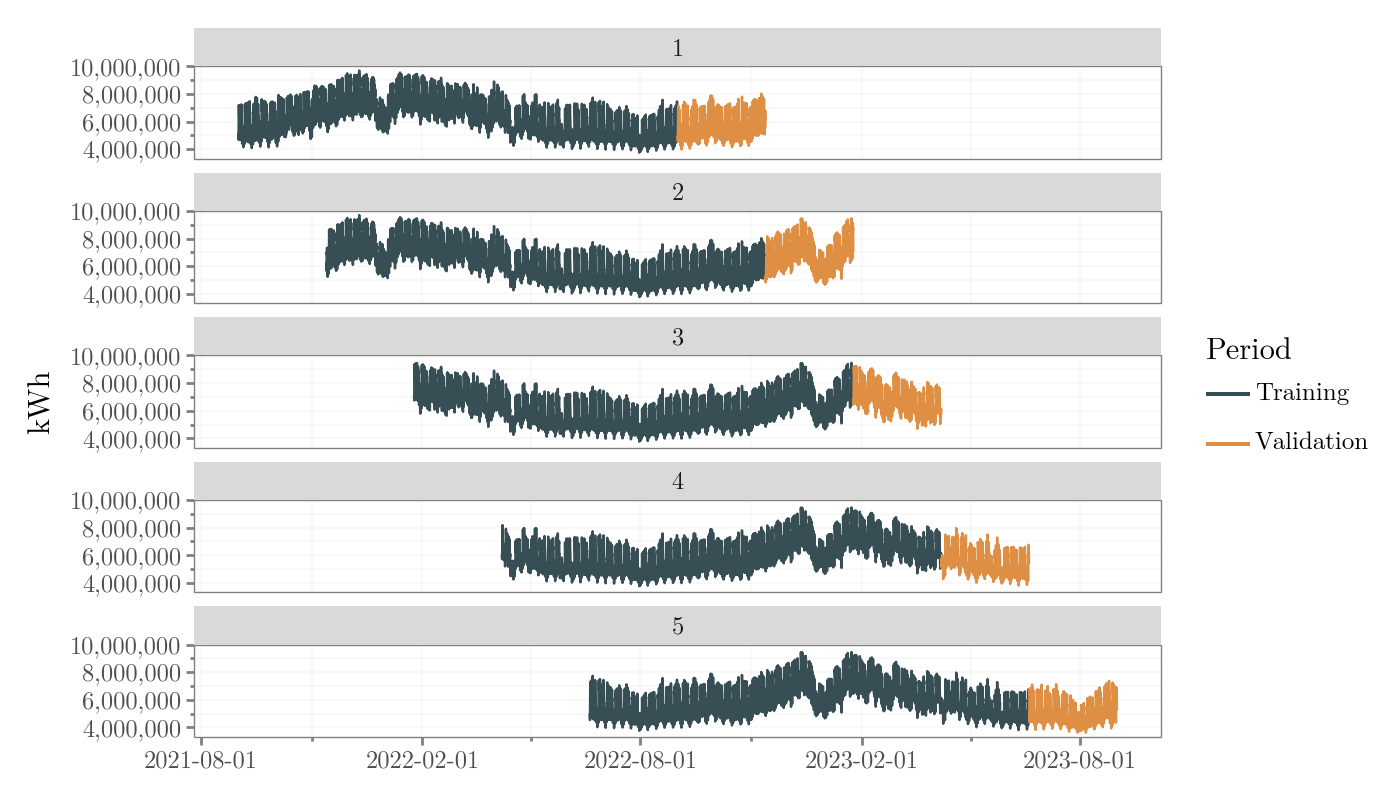

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 4 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/ridge_cv_splits.pdf
matplotlib.font_manager INFO  Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


In [172]:
plot_width = 7
plot_height = 4

fig = (
    pn.ggplot(
        data=pd.concat(target_splits),
        mapping=pn.aes(x="datetime", y="kWh", colour="Period"),
    )
    + pn.geom_line()
    + pn.facet_wrap("~ split", ncol=1)
    + pn.scale_colour_manual(values=jama_colour)
    + pn.scale_y_continuous(labels=comma_format())
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height), axis_title_x=pn.element_blank())
)

display(fig)

fig.save(
    filename="../1_figures/ridge_cv_splits.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

## Manually Fitting a Model

In [173]:
y_preds = []

for split_idx in range(tscv.get_n_splits()):

    # Fit the model
    model = Ridge()
    model.fit(X=X_train_preprocessed_list[split_idx], y=y_train_list[split_idx])

    # Make predictions
    y_pred = model.predict(X=X_val_preprocessed_list[split_idx])
    y_preds.append(y_pred)

    # Calculate loss
    loss = root_mean_squared_error(y_pred=y_pred, y_true=y_val_list[split_idx])

y_preds_val = (
    pd.concat(target_splits)
    .query("Period == 'Validation'")
    .assign(pred=np.vstack(y_preds).flatten())
)

In [174]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    y_preds_val.reset_index(),
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

## Manual Tuning Setup

Repeat the same as manual fit (train/val split), but do order selection via OptunaSearch

In [179]:
def ridge_trainable(config):

    cv_losses = np.array([])

    for split_idx in range(tscv.get_n_splits()):

        # Fit the model
        model = Ridge(alpha=config["alpha"])
        model.fit(X=X_train_preprocessed_list[split_idx], y=y_train_list[split_idx])

        # Make predictions
        y_pred = model.predict(X=X_val_preprocessed_list[split_idx])

        # Calculate loss
        loss = root_mean_squared_error(y_pred=y_pred, y_true=y_val_list[split_idx])
        cv_losses = np.append(cv_losses, loss)

    # train.report({"loss": np.mean(cv_losses)})
    return loss

In [203]:
alpha_grid = np.linspace(1, 100, 100)
cv_losses = []

for alpha in tqdm(alpha_grid):
    loss = ridge_trainable(config={"alpha": alpha})
    cv_losses.append(loss)

  0%|          | 0/100 [00:00<?, ?it/s]

In [204]:
pd.DataFrame({"alpha": alpha_grid, "loss": cv_losses}).to_csv(
    "5_RIDGE_trials.csv", index=False
)

# Validation Performance of the Best Model

In [205]:
trials_df = pl.read_csv("5_RIDGE_trials.csv")

In [206]:
trials_df.shape[0]

100

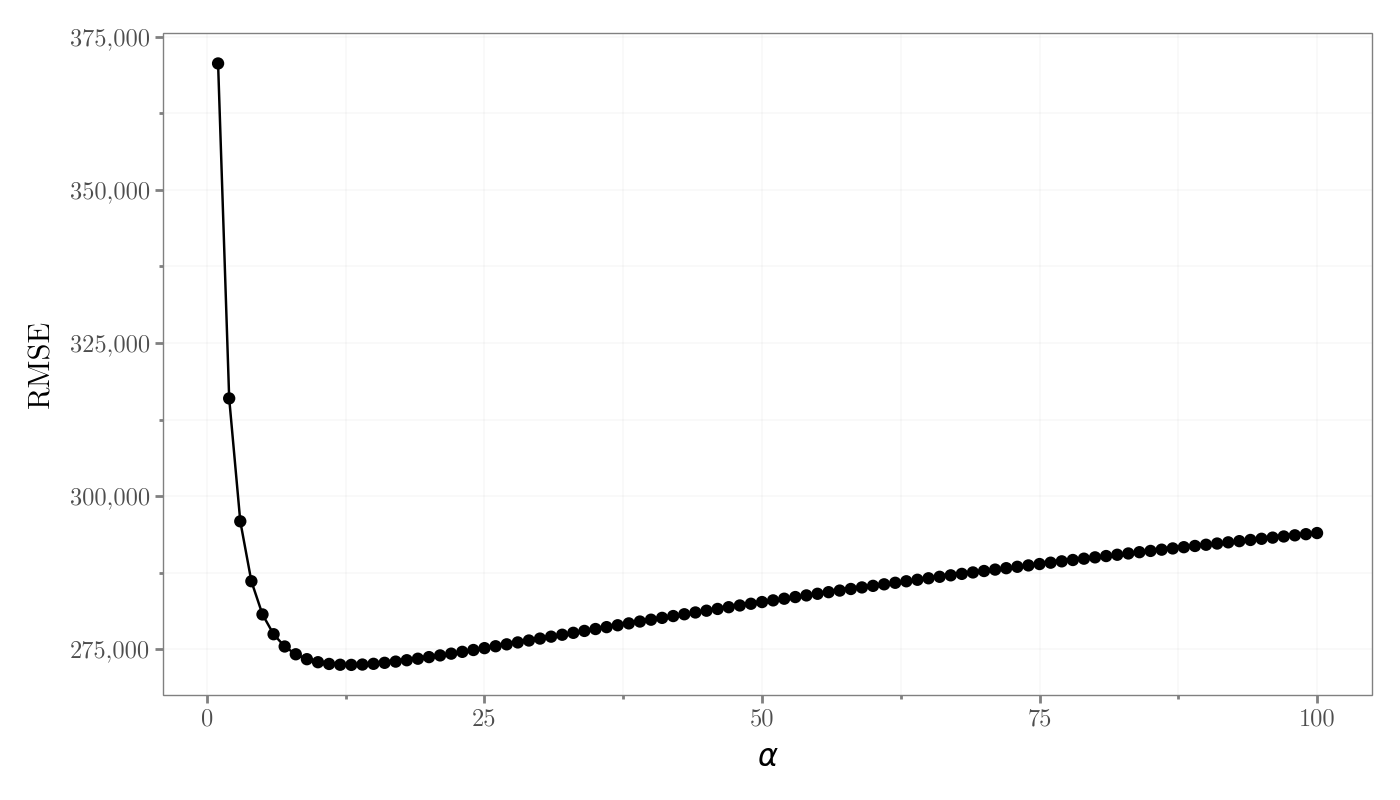

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning:

Saving 7 x 4 in image.

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning:

Filename: ../1_figures/ridge_alpha_loss.pdf



In [207]:
plot_width = 7
plot_height = 4

fig = (
    pn.ggplot(data=trials_df, mapping=pn.aes("alpha", "loss"))
    + pn.geom_line()
    + pn.geom_point()
    + pn.scale_y_continuous(labels=comma_format())
    + pn.labs(y="RMSE", x="$\\alpha$")
    # + pn.geom_smooth(size=0.33, colour="blue")
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height))
)

display(fig)

fig.save(
    filename="../1_figures/ridge_alpha_loss.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

In [212]:
best_alpha = trials_df.sort("loss")["alpha"][0]
best_alpha

13.0

In [213]:
y_preds = []

for split_idx in range(tscv.get_n_splits()):

    # Fit the model
    model = Ridge(alpha=best_alpha)
    model.fit(X=X_train_preprocessed_list[split_idx], y=y_train_list[split_idx])

    # Make predictions
    y_pred = model.predict(X=X_val_preprocessed_list[split_idx])
    y_preds.append(y_pred)

    # Calculate loss
    loss = root_mean_squared_error(y_pred=y_pred, y_true=y_val_list[split_idx])

y_preds_val = (
    pd.concat(target_splits)
    .query("Period == 'Validation'")
    .assign(pred=np.vstack(y_preds).flatten())
)

In [214]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    y_preds_val.reset_index(),
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

# Holdout Evaluation with Retraining

Experimental setup: Weekly retraining on historical data, then predict the entire next week without retraining.

- Training Size: Can set to a long period, as the computational complexity is much lower

In [215]:
trials_df = pl.read_csv("5_RIDGE_trials.csv")

In [216]:
best_alpha = trials_df.sort("loss")["alpha"][0]
best_alpha

13.0

In [217]:
df_trainval = df_full["2021-09-01":"2023-08-31"]
df_holdout = df_full["2023-09-01":"2024-08-31"]

In [218]:
df_holdout.reset_index().filter(["datetime"]).assign(
    delta=lambda x: x.datetime - x.datetime.shift(1)
)["delta"].value_counts()

delta
0 days 01:00:00    8783
Name: count, dtype: int64

In [220]:
retraining_freq = 7 * 24
retraining_indices = np.arange(0, df_holdout.shape[0], retraining_freq).tolist()
y_preds = []

for holdout_index in tqdm(retraining_indices):

    # Preprocess training history df
    X_train = pd.concat(
        [
            df_trainval.iloc[holdout_index:].drop(columns=["kWh"]),
            df_holdout.iloc[:holdout_index].drop(columns=["kWh"]),
        ],
        axis=0,
    )
    X_train_preprocessed = pd.DataFrame(
        preprocessor.fit_transform(X_train),
        columns=preprocessor.get_feature_names_out(),
    )

    X_holdout = df_holdout.iloc[holdout_index : holdout_index + retraining_freq].drop(
        columns=["kWh"]
    )
    X_holdout_preprocessed = pd.DataFrame(
        preprocessor.transform(X_holdout),
        columns=preprocessor.get_feature_names_out(),
    )

    y_train = pd.concat(
        [
            df_trainval.iloc[holdout_index:]["kWh"],
            df_holdout.iloc[:holdout_index]["kWh"],
        ],
        axis=0,
    )
    y_holdout = df_holdout.iloc[holdout_index : holdout_index + retraining_freq]["kWh"]

    # Fit model with best hyperparameters on history (e.g. 1 year)
    model = Ridge(alpha=best_alpha)
    model = model.fit(X=X_train_preprocessed, y=y_train)

    # Make predictions for that week and store them
    y_pred = pd.DataFrame(
        {"pred": model.predict(X=X_holdout_preprocessed), "kWh": y_holdout}
    )
    y_preds.append(y_pred)

    # Increment holdout index
    holdout_index += retraining_freq

  0%|          | 0/53 [00:00<?, ?it/s]

In [224]:
holdout_preds = pd.concat(y_preds).reset_index()
holdout_preds.head()

,datetime,pred,kWh
0,2023-09-01 00:00:00,5.222627e+06,4.952079e+06
1,2023-09-01 01:00:00,5.092112e+06,4.789383e+06
2,2023-09-01 02:00:00,4.965551e+06,4.689283e+06
3,2023-09-01 03:00:00,4.865860e+06,4.490485e+06
4,2023-09-01 04:00:00,4.787547e+06,4.345052e+06


In [225]:
holdout_preds.to_csv("5_RIDGE_holdout_predictions.csv", index=False)

In [226]:
root_mean_squared_error(y_true=holdout_preds["kWh"], y_pred=holdout_preds["pred"])

342340.647151205

In [222]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    pd.concat(y_preds).reset_index(),
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()